### Riddler Express

From Gary Yane comes a question that launched a million flips:

I have in my possession 1 million fair coins. Before you ask, these are not legal tender. Among these, I want to find the “luckiest” coin.

I first flip all 1 million coins simultaneously (I’m great at multitasking like that), discarding any coins that come up tails. I flip all the coins that come up heads a second time, and I again discard any of these coins that come up tails. I repeat this process, over and over again. If at any point I am left with one coin, I declare that to be the “luckiest” coin.

But getting to one coin is no sure thing. For example, I might find myself with two coins, flip both of them and have both come up tails. Then I would have zero coins, never having had exactly one coin.

What is the probability that I will — at some point — have exactly one “luckiest” coin?

#### computational solution

Test case:
- build `n` sets of `m` flips. 
- Want to use vectorization to solve this problem more quickly than looping. 

First, let's confirm we get similar results as if we did all of this as a loop

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt

n = 10_000 # 1000 games
m = 10_000 # 1000 flips each
wins = 0
s = time.time()
# iterate row by row - much slower
for _ in range(n):   
    flips = np.random.randint(0,2, size = m)
    
    while True:
        # drop any flips that aren't heads (heads = 1)
        size = len(flips[np.where(flips == 1)])

        if size == 1:
            wins += 1
            break
        if size == 0:
            break
            
        # flip again based on remaining heads (1s)
        flips = np.random.randint(low = 0, high = 2, size = size)
        
print(f"Total win %: {wins / n: .2f}")
print(f"Total time: {time.time() - s}")

Total win %:  0.72
Total time: 1.941014051437378


#### Vectorized Approach:

Let's solve in one pass through, should be much faster.

In [2]:
# build our first full matrix
m1 = np.random.randint(0,2,(n,m))
w = 0 
l = 0 
s = time.time()

while True:
    # we rebuild with original size -> but now let's say that a heads is a 0 so we can keep tabs on remaining. 
    m2 = np.random.randint(0,2,(n,m))

    # A diff of 1 now indicates we still have a heads, anything else indicates a tails. 
    # We can just keep doing subtraction on a new matrix
    # then can do a quick where statement for each row to determine wins or losses 
    diff = m1 - m2

    # find row counts of heads and tails: 
    heads = np.sum(diff==1, axis=1)
    tails = np.sum(diff==0, axis=1)

    # find wins: 
    wins = np.where(heads == 1)
    w += wins[0].shape[0] # add wins

    # find losses: we need heads to be 0 and we need at least a tails indicating still active
    losses = np.where((heads == 0) & (tails > 0))
    l += losses[0].shape[0] # add losses

    # set all row wins to -1 so we don't recount in losses
    diff[wins] = -1
    diff[losses] = -1 # same with losses to not double count

    if (w + l) == n:
        print(f"Total win %: {w / (w+l): .2f}")
        print(f"Total time: {time.time() - s}")
        break

    # move into another
    m1 = diff.copy()

Total win %:  0.73
Total time: 17.27840805053711


#### Single Matrix ~10x slower - Why?

My assumption is either:
- a) I did this incorrectly and am not leaning on vectorization
- b) My matrix size is so large and so repetitive that it gets no speed boost from vectorization of matrix. 
    - I could not think of another way to keep the necessary information, which means instead of whittling down an `n x m` matrix to a smaller set, I just keep doing subtraction on `n x m` matrices, which is going to get pretty memory intensive.
    - I think if the `n x m` was small this would outperform the `for loop` approach, but we are dealing with some pretty sizable matrices here (10K x 10K = 100MM elements)
    - For now, it seems iteration 10K times of 10K vector that shrinks each step is going to be faster, very surprising. 
    - Multiprocessing would probably make sense for a problem like this, adding as a TODO.

Likely better computational ways to solve this, but for now I will lean on iteration & convergence.

### 1 Million Is Too Big To Test In A Loop:

1 million takes a lot memory that I don't have & likely requires a smarter approach. I am going to attempt to converge with a fairly large number of flips each game (`5K`), and increment game size by `1000`. 

Plotting this out, we should be able to see a convergence point. 

In [3]:
# we first get idxs for heads
results = {}
time_res = {}
very_start = time.time()
n_list = list(range(1_000, 101_000, 1_000)) # total games at once, in steps of 1_000
m = 5_000 # flips at once

for n in n_list:
    wins = 0
    s = time.time()
    # iterate over each game, will get very slow
    for _ in range(n):   
        flips = np.random.randint(0,2, size = m)

        while True:
            # drop any flips that aren't heads (heads = 1)
            size = len(flips[np.where(flips == 1)])

            if size == 1:
                wins += 1
                break
            if size == 0:
                break

            # flip again based on remaining heads (1s)
            flips = np.random.randint(low = 0, high = 2, size = size)
    tot_time = time.time() - s
    results[n] = wins
    time_res[n] = tot_time
    
    if n % 10_000 == 0:
        print(f"Finished {n} game iteration in {tot_time:.2f} seconds")
        print(f"Cumulative time: {time.time() - very_start:.2f} seconds")

Finished 10000 game iteration in 1.21 seconds
Cumulative time: 6.68 seconds
Finished 20000 game iteration in 2.43 seconds
Cumulative time: 25.57 seconds
Finished 30000 game iteration in 3.68 seconds
Cumulative time: 56.75 seconds
Finished 40000 game iteration in 4.94 seconds
Cumulative time: 100.34 seconds
Finished 50000 game iteration in 6.21 seconds
Cumulative time: 156.62 seconds
Finished 60000 game iteration in 7.50 seconds
Cumulative time: 226.13 seconds
Finished 70000 game iteration in 8.68 seconds
Cumulative time: 307.76 seconds
Finished 80000 game iteration in 10.31 seconds
Cumulative time: 402.48 seconds
Finished 90000 game iteration in 11.15 seconds
Cumulative time: 508.82 seconds
Finished 100000 game iteration in 12.39 seconds
Cumulative time: 626.81 seconds


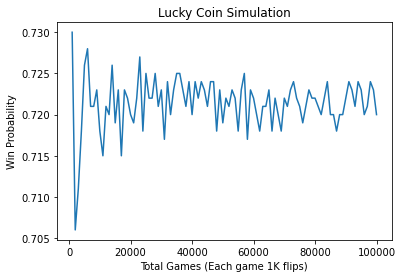

In [4]:
# Plot Solutions
final_solutions = [round(v/k,3) for k,v in results.items()]
plt.plot(results.keys(), final_solutions)
plt.xlabel("Total Games (Each game 1K flips)")
plt.ylabel("Win Probability")
plt.title("Lucky Coin Simulation");

In [5]:
# Take mean of last 10 estimates
print(f"Final converged win probability: {round(np.mean(final_solutions[-10:]),2)}")

Final converged win probability: 0.72
